In [368]:
import sys
sys.path.append("../../..")


In [418]:
import numpy as  np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from synthetic_data_generation.syn_gyn_module import *
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.3f}'.format
import numpy as np

# Generate example data

In [419]:
# Unit: number of products
num_units = 100

# Time: number of observations
max_timesteps = 52*7

# Metrics
sales = Metric("sales", metric_range = [0,30000] )
metrics = [sales]

# Interventions: control(no promo), (Email reminders), (20$ off)
num_interventions = 3


# unit covariates: location and size
type = UnitCov("category", categories= ["Activewear", "Outerwear", "Underwear"])
gender = UnitCov("size", categories= ["Men's Wear", "Women's Wear", "Unisex", "Children's Wear"])
X1 = UnitCov("x1", categories= [0,1])

gender = UnitCov("size", categories= ["Men's Wear", "Women's Wear", "Unisex", "Children's Wear"])

unit_cov = [type, gender]
for i in range(10):
    unit_cov.append(UnitCov(f"x{i}", categories= [0,1]))

# intervention covariates: 
# Note that the assignments here makes the association between control and intervention 0, Email reminders and intervention 1, etc ..
treatment = IntCov("promo", discrete = True, categories= ["control","Email promo","20$ off coupons"], divisions = 3, assignment= [0,1,2])
int_cov = [treatment]

# initalize and generate
data = SyntheticDataModule(num_units, max_timesteps, num_interventions, metrics, unit_cov, int_cov , freq = "1w", rank = 4, 
                           start =  pd.Timestamp("01/01/2014 00:00"),)




In [426]:
data.generate_init_factors(periods = [52,52,24, 24], max_amp_har= 0.1, min_amp_har=-0.1, lin_tren= True, trend_coeff=[0.0002]*4)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/clust

In [427]:
# Now we will define differen subpopulations andd specific effects on them for each intervention

# choose sub populations of interest where interventions will have different effects
subpop1 = lambda :type.unit_labels == 'Activewear'
subpop2 = lambda :type.unit_labels == 'Outerwear'
subpop3 = lambda :type.unit_labels == 'Underwear'
data.subpopulations_funcs = [subpop1, subpop2, subpop3]

# We will assume that intervention 1 will incure an increase of 10% in sales for subpop3
#  and 2 will incure an increase of 10% in sales for all subpops
effects = [
   {"metric": sales, "intervention": 1, "subpop": subpop3, "effect": 0.2},
   {"metric": sales, "intervention": 2, "subpop": subpop2, "effect": 0.1}, 
    {"metric": sales, "intervention": 2, "subpop": subpop1, "effect": 0.1}, 
        ]

data.add_effects(effects)



In [428]:
# How to assign interventions? I.e., how to subsample the tensor?
# you do that by definine sequential periods, each period will to choose two things:
    # intervention_assignment: must be one of:
            #  random: completely at random
            #  random_unit: random for each unit (but constant in time)
            #  cov_unit: based on a covariate of the unit (could be randomized)
            #  or control: use control
    # unitl (integer): use this assignment from the last assigned point until this point in (relative) time.
# control example
t0 = 0
t1 = 3*52
period_1 =  {"intervention_assignment": "control", "until": t1-1}

# cov_unit example
# cov unit also need "assignment_subpop" policy which is a dictionary of subpopulations (keys) and probability of assignment (list of float in [0,1] that must be of length (num_interventions) and must sum to one)
t1 = 7*52
intervention_assignment = "cov_unit"
selection_subpop = {subpop1 : [0.30,0.2,0.5], subpop2 : [0.30,0.4,0.3], subpop3: [0.3, 0.5, 0.2] }
period_2 = {"intervention_assignment": intervention_assignment, "until": t1, "assignment_subpop": selection_subpop}

periods = [period_1, period_2]

tensor, df , tensor_noisy = data.generate([t0,t1-1], std= 0.1)
tensor_ss, df_ss = data.auto_subsample(periods, tensor_noisy, df)
df_ss

(100, 364, 3, 1)
(100, 364, 3, 1)


,unit_id,time,category,size,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,intervention,sales,promo
0,0,2014-01-05,Outerwear,Men's Wear,0,0,0,0,1,1,0,1,0,0,0,"30,431.021",control
1,0,2014-01-12,Outerwear,Men's Wear,0,0,0,0,1,1,0,1,0,0,0,"29,573.354",control
2,0,2014-01-19,Outerwear,Men's Wear,0,0,0,0,1,1,0,1,0,0,0,"31,817.685",control
3,0,2014-01-26,Outerwear,Men's Wear,0,0,0,0,1,1,0,1,0,0,0,"30,703.284",control
4,0,2014-02-02,Outerwear,Men's Wear,0,0,0,0,1,1,0,1,0,0,0,"30,980.269",control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36395,99,2020-11-22,Underwear,Unisex,0,0,0,0,1,1,1,1,0,0,0,"26,933.519",control
36396,99,2020-11-29,Underwear,Unisex,0,0,0,0,1,1,1,1,0,0,0,"26,937.903",control
36397,99,2020-12-06,Underwear,Unisex,0,0,0,0,1,1,1,1,0,0,0,"28,485.463",control
36398,99,2020-12-13,Underwear,Unisex,0,0,0,0,1,1,1,1,0,0,0,"28,420.232",control


In [429]:
tensor, df_no_noise , _ = data.generate([t0,t1-1], std= 0.0)


(100, 364, 3, 1)
(100, 364, 3, 1)


<Axes: xlabel='time'>

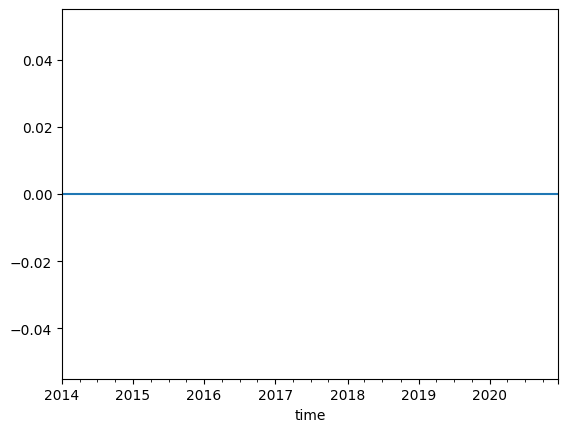

In [430]:
df_ss.index = df_ss.time

unit = 9
df_ss.loc[df_ss.unit_id == unit, 'intervention'].plot()


<Axes: xlabel='time'>

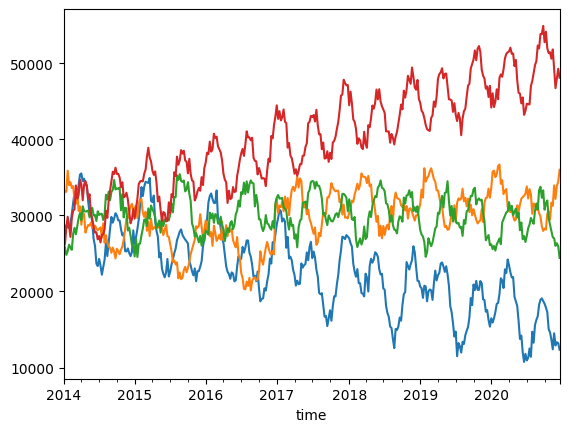

In [431]:
unit = 9
df_ss.loc[df_ss.unit_id == unit, 'sales'].plot()
unit = 20
df_ss.loc[df_ss.unit_id == unit, 'sales'].plot()
unit = 68
df_ss.loc[df_ss.unit_id == unit, 'sales'].plot()
unit = 87
df_ss.loc[df_ss.unit_id == unit, 'sales'].plot()


### plot data from full tensor for unit 0 at different interventions

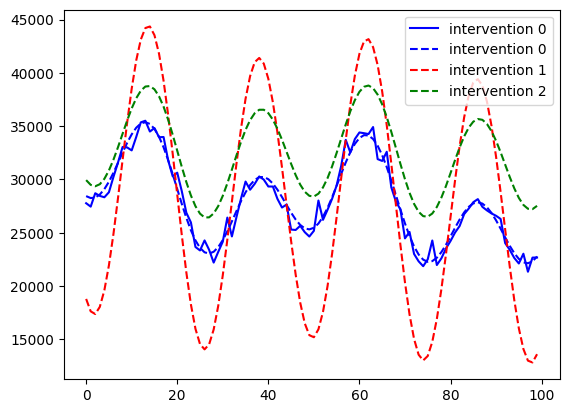

In [432]:
unit = 9

plt.plot(tensor_noisy[unit,:100,0,], 'b-', label = "intervention 0")
plt.plot(tensor[unit,:100,0,], 'b--', label = "intervention 0")
# plt.plot(tensor_noisy[unit,:100,1,], 'r-', label = "intervention 1")
plt.plot(tensor[unit,:100,1,], 'r--', label = "intervention 1")

# plt.plot(tensor_noisy[unit,:100,2,], 'g-', label = "intervention 2")
plt.plot(tensor[unit,:100,2,], 'g--', label = "intervention 2")

plt.legend()
plt.show()

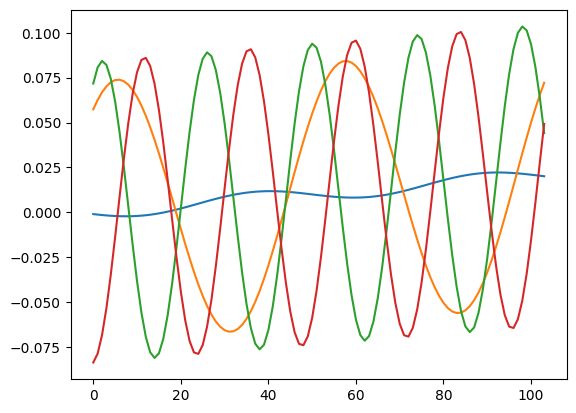

In [433]:
plt.plot(data.factors[1][:104,:])

In [434]:
1/data.time_factor_periods

array([52., 52., 24., 24.])

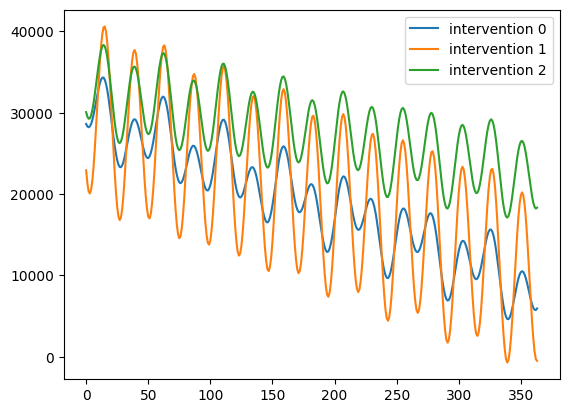

In [435]:
unit = 3
plt.plot(tensor[unit,:,0,], label = "intervention 0")
plt.plot(tensor[unit,:,1,], label = "intervention 1")
plt.plot(tensor[unit,:,2,], label = "intervention 2")
plt.legend()
plt.show()

# export data

In [436]:
data.export("product_sales",tensor, df_ss, dir = "" )

In [306]:
tensor.shape

(100, 364, 3, 1)